# Classification (BERT-Base)
## MI201

##**Group 4** :
- Diego FLEURY CORRÊA DE MORAES
- Hazael SOLEDADE DE ARAUJO JUMONJI
- Lucas DE OLIVEIRA MARTIM

### Project 3 : **Sentiment Analysis Using LLMs**

In [ ]:
! git clone https://github.com/DiegoFleury/MI201-groupe-4.git

Cloning into 'MI201-groupe-4'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 260 (delta 33), reused 12 (delta 3), pack-reused 198 (from 2)
Receiving objects: 100% (260/260), 242.77 MiB | 14.03 MiB/s, done.
Resolving deltas: 100% (120/120), done.


# Importing and Installing libraries

In [ ]:
! pip install umap-learn numba llamaapi

In [ ]:
# Data handling
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Text preprocessing
import re
import unicodedata

# BERT
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Deep learning
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Dimensionality reduction
import umap
import numba
from sklearn.manifold import TSNE

# Classic ML models
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost

# Model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# LLM API
import json
from llamaapi import LlamaAPI
import time

# LoRA
from peft import LoraConfig, get_peft_model, TaskType
from transformers import TrainingArguments
import os

# Data Handling

## Initializing the DataFrames

In [ ]:
data_path = "MI201-groupe-4/Data/"

In [ ]:
# Load the data
train_full = pd.read_csv(data_path + 'processed_train.csv')
test_full =  pd.read_csv(data_path + 'processed_test.csv')

# Drop any null values
train_full.dropna(inplace=True)
test_full.dropna(inplace=True)

# Perform the proper separation of functions of each dataset
X_train, X_val, y_train, y_val = train_test_split(train_full['Text'], train_full['Sentiment'], test_size=0.2, random_state=42)
X_test, y_test = test_full['Text'], test_full['Sentiment']

# Correct the indexes of all tables
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

## Preprocessing the DataFrames

In [ ]:
# Preprocessing the text, just enough to not lose any important features

def preprocess_text(text):
    """
    Text preprocessing, removing accents, links, HTML, extra spaces and user names.

    - Converts to lowercase.
    - Removes accents.
    - Removes HTML tags.
    - Remove links (http, https, www).
    - Removes extra spaces.
    - Removes user names.
    """

    if not isinstance(text, str):
        return ""

    # Lowercase
    text = text.lower()

    # Strip all accents
    text = ''.join(c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn')

    # Removes links (http, https, www)
    text = re.sub(r"http\S+|www\S+", "", text)

    # Removes HTML tags
    text = re.sub(r"<.*?>", "", text)

    # Removes usernames
    text = re.sub(r"@\w+", "", text)

    # Removes line breaks and excessive whitespaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Also need to preprocess the labels. Mapping made like this to preserve
# the ordinal character of the feature. Also, isn't zero-centered
# due to the input requirements of XGBoost
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

In [ ]:
# Apply the preprocessing to the features
X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [ ]:
X_train

,Text
0,"oh, he`s hilarious. i`m just commenting on the..."
1,"thanks for trying i was hoping bud trillin, bu..."
2,after show at our house rocked! saying goodbye...
3,up at 4:30am west coast time..gettin ready to ...
4,my computer is so slooowww this morning. i thi...
...,...
21979,feels like warm things
21980,my best friend is in vegas without me
21981,- fire and urban at rock challenge
21982,a+ for effort though


In [ ]:
# Apply the preprocessing to the labels
y_train = y_train.map(sentiment_mapping)
y_val = y_val.map(sentiment_mapping)
y_test = y_test.map(sentiment_mapping)

In [ ]:
y_train

,Sentiment
0,2
1,2
2,1
3,2
4,1
...,...
21979,1
21980,1
21981,1
21982,2


## Creating Pytorch Data Objects

In [ ]:
# Custom Dataset object created to store the original texts
# and return them in the form of it's tokenizer's parameters (ids, attention mask) and label
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Args:
            texts (DataFrame): DataFrame with the text samples.
            labels (DataFrame): DataFrame of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Custom Dataset object created to store the embedded version of each text ()
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            embeddings (numpy array): Representation of embedding of the hole text ([CLS] token with context).
            labels (DataFrame): DataFrame of sentiment labels (e.g., 0, 1).
        """
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        embeddings = self.embeddings[idx]
        label = self.labels[idx]

        return {
            "input_ids": embeddings,
            "label": torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Extract embeddings for all data
# effectively converting from one representation (Text) to the other (Embedding)
def extract_embeddings(model, dataloader, device):
    """
    Extracts embeddings for all data using a pre-trained BERT model.

    Args:
        model (transformers.BertModel): Pre-trained BERT model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        torch.Tensor: A matrix of size (number_of_samples, embedding_size).
    """
    model.eval()  # Set the model to evaluation mode
    embeddings = []

    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Forward pass through BERT
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output  # CLS token representation

            # Append embeddings to the list
            embeddings.append(pooled_output.cpu())

    # Combine all embeddings into a single matrix
    return torch.cat(embeddings, dim=0)

In [ ]:
# Hyperparameters
PRETRAINED_MODEL = "bert-base-uncased"
MAX_LENGTH = 256 # Tweets can have at most 280 characters, but let's keep it a power of 2
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

# Initialize the datasets
train_dataset = TextDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = TextDataset(X_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = TextDataset(X_test, y_test, tokenizer, MAX_LENGTH)

# Initialize the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def process_embeddings(extract_embeddings, data_loader, model_name, device, file_path):
    """
    Processes embeddings for a given dataset.

    If file_path exists, loads embeddings from the file.
    Otherwise, extracts embeddings using the model and saves them.

    Args:
        extract_embeddings: Function to extract embeddings.
        data_loader: DataLoader for the dataset.
        model_name: Name of the pre-trained model.
        device: Execution device (cuda or cpu).
        file_path: Path to save or load embeddings.

    Returns:
        embeddings : Matrix of size (number_of_samples, embedding_size).
    """
    if file_path:
        try:
            embeddings = np.load(file_path)
            return embeddings
        except FileNotFoundError:
            pass

    # Load model
    bert = AutoModel.from_pretrained(model_name).to(device)

    # Extract embeddings
    embeddings = extract_embeddings(bert, data_loader, device).cpu().numpy()

    # Save embeddings
    np.save(file_path, embeddings)

    return embeddings

In [ ]:
train_embeddings = process_embeddings(extract_embeddings, train_loader, PRETRAINED_MODEL, device, data_path + "bert_train_embeddings.npy")
val_embeddings = process_embeddings(extract_embeddings, val_loader, PRETRAINED_MODEL, device,     data_path + "bert_val_embeddings.npy")
test_embeddings = process_embeddings(extract_embeddings, test_loader, PRETRAINED_MODEL, device,   data_path + "bert_test_embeddings.npy")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
train_embeddings.shape, val_embeddings.shape, test_embeddings.shape

((21984, 768), (5496, 768), (3534, 768))

In [ ]:
# Initialize the embedding datasets
embedding_train_dataset = EmbeddingDataset(train_embeddings, y_train)
embedding_val_dataset = EmbeddingDataset(val_embeddings, y_val)
embedding_test_dataset = EmbeddingDataset(test_embeddings, y_test)

# Initialize the embedding dataloaders
embedding_train_loader = DataLoader(embedding_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
embedding_val_loader = DataLoader(embedding_val_dataset, batch_size=BATCH_SIZE, shuffle=True)
embedding_test_loader = DataLoader(embedding_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Feature-Based

### UMAP

In [ ]:
umap_model = umap.UMAP(n_components=50, n_neighbors=30, min_dist=0.1, metric = "cosine")

In [ ]:
def process_umap_transform(umap_model, embeddings, file_path):
    """
    Applies UMAP transformation to embeddings.

    If file_path exists, loads transformed embeddings from the file.
    Otherwise, applies UMAP and saves the transformed embeddings.

    Args:
        umap_model: Pre-trained UMAP model.
        embeddings: Original embeddings to be transformed.
        file_path: Path to save or load transformed embeddings.

    Returns:
        Transformed embeddings.
    """
    if file_path:
        try:
            transformed_embeddings = np.load(file_path)
            return transformed_embeddings
        except FileNotFoundError:
            pass

    transformed_embeddings = umap_model.fit_transform(embeddings) if 'train' in file_path else umap_model.transform(embeddings)
    np.save(file_path, transformed_embeddings)
    return transformed_embeddings

In [ ]:
train_embeddings_umap = process_umap_transform(umap_model, train_embeddings, data_path + "bert_train_embeddings_umap.npy")
val_embeddings_umap = process_umap_transform(umap_model, val_embeddings, data_path + "bert_val_embeddings_umap.npy")
test_embeddings_umap = process_umap_transform(umap_model, test_embeddings, data_path + "bert_test_embeddings_umap.npy")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
train_embeddings.shape, train_embeddings_umap.shape

((21984, 768), (21984, 50))

**Q0** - please analyse the datasets with classical ML algorithms

Let's analyse the quality of the UMAP embeddings. T-SNE is likely the best option to perform this.

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

train_embeddings_umap_tsne = tsne.fit_transform(train_embeddings_umap)
val_embeddings_umap_tsne = tsne.fit_transform(val_embeddings_umap)
test_embeddings_umap_tsne = tsne.fit_transform(test_embeddings_umap)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


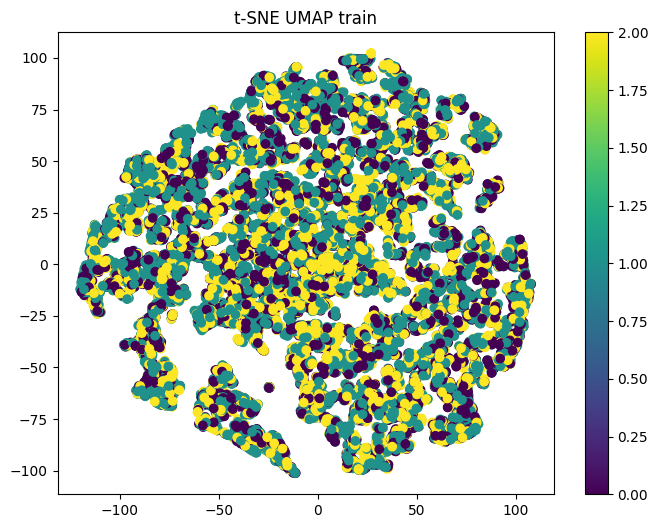

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(train_embeddings_umap_tsne[:, 0], train_embeddings_umap_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('t-SNE UMAP train')
plt.show()

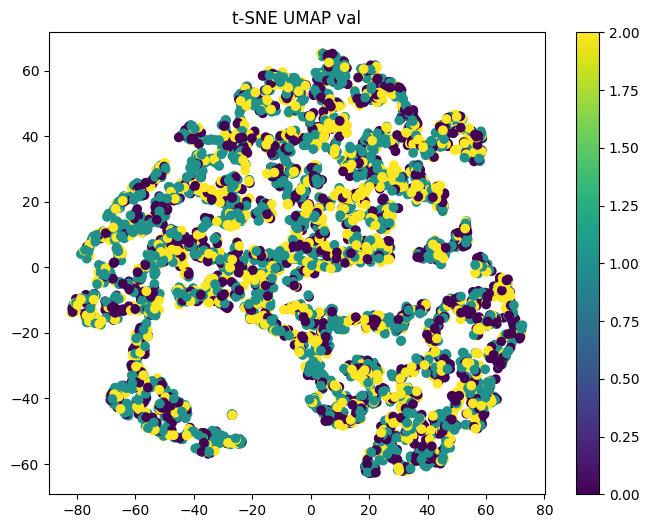

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(val_embeddings_umap_tsne[:, 0], val_embeddings_umap_tsne[:, 1], c=y_val, cmap='viridis')
plt.colorbar()
plt.title('t-SNE UMAP val')
plt.show()

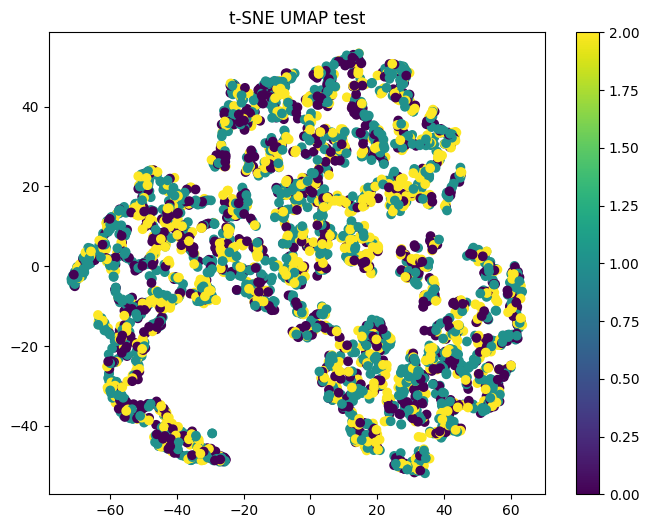

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(test_embeddings_umap_tsne[:, 0], test_embeddings_umap_tsne[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.title('t-SNE UMAP test')
plt.show()

### Logistic Regression

In [ ]:
# Criar e treinar o modelo de Regressão Logística
logreg = LogisticRegression(
    max_iter=500,       # Número máximo de iterações para convergência
    C=1.0,              # Regularização (1.0 = padrão, pode ajustar)
    solver="lbfgs",     # Otimizador (funciona bem para embeddings grandes)
    multi_class="multinomial",  # Para classificação multiclasse
    n_jobs=-1           # Usa múltiplos núcleos da CPU
)

logreg.fit(train_embeddings_umap, y_train)

# Avaliação
accuracy = logreg.score(val_embeddings_umap, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy: 0.4067


### SVM


In [ ]:
svm_sgd = SGDClassifier(loss='hinge', alpha=0.01, max_iter=2000, tol=1e-3)
svm_sgd.fit(train_embeddings_umap, y_train)

print(f"Accuracy: {svm_sgd.score(val_embeddings_umap, y_val):.4f}")

Accuracy: 0.4061


In [ ]:
svm = LinearSVC(C=1.0, max_iter=5000)
svm.fit(train_embeddings_umap, y_train)

print(f"Validation Accuracy: {svm.score(val_embeddings_umap, y_val):.4f}")

Validation Accuracy: 0.4099


### Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)

rf.fit(train_embeddings_umap, y_train)

accuracy = rf.score(val_embeddings_umap, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.4356


### XGBoost

In [ ]:
xgb = XGBClassifier(
    n_estimators=100,  # Number of trees
    max_depth=5,       # Maximum depth of each tree
    learning_rate=0.01, # Learning rate of the ensemble
    use_label_encoder=False,  # To avoid unnecessary warnings
    eval_metric="mlogloss"  # Multiclass classification metric
)

xgb.fit(train_embeddings_umap, y_train)

accuracy = xgb.score(val_embeddings_umap, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:38:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy: 0.4289


Lets take only the random forest classifier as a model to be tested further (not suprisingly, an ensemble methods!). It's the second best performing and we've had some issues with the library version for xgboost.

In [ ]:
def perform_grid_search(model, param_grid, X, y, cv=2, scoring='accuracy', verbose=10):
    """
    Performs GridSearchCV for a given model and parameter grid.

    Args:
        model: The machine learning model.
        param_grid: Dictionary of hyperparameters to search.
        X: Feature matrix.
        y: Target labels.
        cv: Number of cross-validation folds (default: 2).
        scoring: Scoring metric (default: 'accuracy').
        verbose: Verbosity level (default: 10).

    Returns:
        Best parameters and best score from the grid search.
    """
    grid = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, verbose=verbose)
    grid.fit(X, y)
    print("Best parameters:", grid.best_params_)
    print("Best accuracy:", grid.best_score_)
    return grid.best_params_, grid.best_score_

In [ ]:
# Random Forest
rf = RandomForestClassifier()

rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10]
}

rf_best_params, _ = perform_grid_search(rf, rf_param_grid, train_embeddings_umap, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2; 1/4] START max_depth=5, n_estimators=100...............................
[CV 1/2; 1/4] END max_depth=5, n_estimators=100;, score=0.421 total time=   5.0s
[CV 2/2; 1/4] START max_depth=5, n_estimators=100...............................
[CV 2/2; 1/4] END max_depth=5, n_estimators=100;, score=0.429 total time=   3.8s
[CV 1/2; 2/4] START max_depth=5, n_estimators=200...............................
[CV 1/2; 2/4] END max_depth=5, n_estimators=200;, score=0.420 total time=   8.2s
[CV 2/2; 2/4] START max_depth=5, n_estimators=200...............................
[CV 2/2; 2/4] END max_depth=5, n_estimators=200;, score=0.426 total time=   8.0s
[CV 1/2; 3/4] START max_depth=10, n_estimators=100..............................
[CV 1/2; 3/4] END max_depth=10, n_estimators=100;, score=0.427 total time=   8.0s
[CV 2/2; 3/4] START max_depth=10, n_estimators=100..............................
[CV 2/2; 3/4] END max_depth=10, n_estimators=100;

In a real life situation we'd test far more models under far more combinations of values and models, but this is just a illustration of the level that classical ML models can achieve in this dataset.

## Neural Network

**Q2** - please perform a classification with a MLP

### Deep Neural Network Classifier

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden1=1024, hidden2=2048, output_dim=3, dropout=0.1):
        super(SentimentClassifier, self).__init__()

        # Activation function
        self.activation = nn.GELU()

        # Main layers (notice the middle increase in size, followed by a decrease)
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden1)
        self.fc4 = nn.Linear(hidden1, input_dim)

        # Output layer (3 classes)
        # Softmax is not here due to the fact that it's implemented
        # fused with the loss for efficiency
        self.fc_out = nn.Linear(input_dim, output_dim)

        # Dropout layer (regularization)
        self.dropout = nn.Dropout(dropout)

        # Batch norm layers (regularization)
        self.bn1 = nn.BatchNorm1d(hidden1)
        self.bn2 = nn.BatchNorm1d(hidden2)
        self.bn3 = nn.BatchNorm1d(hidden1)

    def forward(self, x):

        # Stores the input to implement skip connections
        skip = x

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.activation(x)

        x = x + skip  # Skip connection

        x = self.fc_out(x)
        return x


### Epoch Loops

In [ ]:
# Training script (assumes it uses the Embedded Dataset)
def train( model, train_loader, optimizer, criterion, epoch,log_interval=50):
    model.train()

    loss_cpu=0
    correct = 0
    total = 0

    for batch_idx, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, target = data['input_ids'],data['label']
        inputs, target = inputs.cuda(), target.cuda()

        # inputs =inputs.detach()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping

        optimizer.step()

        # Softmax here
        _, predicted = torch.max(outputs.data, 1)
        loss_cpu+= loss.item()
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()

        if batch_idx % log_interval == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, EPOCHS, batch_idx+1,
                    (len(train_loader)//BATCH_SIZE)+1, loss.item(), 100.*correct/total))
            #n_iter=epoch * len(train_loader) + batch_idx

    return loss_cpu/len(train_loader)

In [ ]:
# Testing script (assumes it uses the Embedded Dataset)
def test( model, test_loader, criterion ,epoch):
    model.eval()

    correct = 0
    total = 0
    test_loss = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0):
            inputs, target = data['input_ids'],data['label']
            inputs, target = inputs.cuda(), target.cuda()

            outputs  = model(inputs)
            loss = criterion(outputs,target)

            # Softmax here
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += predicted.eq(target.data).cpu().sum()
            test_loss += loss.item()

    test_loss = test_loss/ len(test_loader)
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), 100.*correct/total))
    return test_loss, 100.*correct/total

### Training

In [ ]:
LEARNING_RATES = [5e-6, 2e-6, 1e-6]
EPOCHS = 60
PATIENCE = 7

# To compare all the losses
all_train_losses = {}
all_val_losses = {}

for lr in LEARNING_RATES:

    print(f"\nTraining with lr = {lr}")

    model = SentimentClassifier().to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # Slight L2 Regularization
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)  # Gradual LR reduction

    train_losses = []
    val_losses = []

    best_val_loss = float("inf")
    patience_counter = 0

    # Go through all epochs
    for epoch in range(EPOCHS):
        train_loss = train(model, embedding_train_loader, optimizer, criterion, epoch)
        val_loss, val_acc = test(model, embedding_val_loader, criterion, epoch)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Update the learning rate with the scheduler
        scheduler.step()

        # Early Stopping: stop if the validation loss hasn't got any better for "PATIENCE" epochs
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"⏹️ Early Stopping activated in epoch {epoch+1} for LR {lr}.")

                # Padding the remaining epochs
                train_losses.extend([train_losses[-1]] * (EPOCHS - len(train_losses)))
                val_losses.extend([val_losses[-1]] * (EPOCHS - len(val_losses)))
                break

    all_train_losses[f"LR {lr}"] = train_losses
    all_val_losses[f"LR {lr}"] = val_losses


Training with lr = 5e-06
| Epoch [  0/ 60] Iter[  1/  6]		Loss: 1.1230 Acc@1: 28.125%
| Epoch [  0/ 60] Iter[ 51/  6]		Loss: 1.0944 Acc@1: 38.695%
| Epoch [  0/ 60] Iter[101/  6]		Loss: 1.0677 Acc@1: 42.234%
| Epoch [  0/ 60] Iter[151/  6]		Loss: 1.1033 Acc@1: 43.874%
| Epoch [  0/ 60] Iter[201/  6]		Loss: 0.9429 Acc@1: 45.507%
| Epoch [  0/ 60] Iter[251/  6]		Loss: 0.9771 Acc@1: 46.688%
| Epoch [  0/ 60] Iter[301/  6]		Loss: 0.9727 Acc@1: 47.669%

| Validation Epoch #0			Loss: 0.9791 Acc@1: 56.40%
| Epoch [  1/ 60] Iter[  1/  6]		Loss: 0.9295 Acc@1: 59.375%
| Epoch [  1/ 60] Iter[ 51/  6]		Loss: 0.8860 Acc@1: 55.331%
| Epoch [  1/ 60] Iter[101/  6]		Loss: 0.9967 Acc@1: 56.204%
| Epoch [  1/ 60] Iter[151/  6]		Loss: 0.9266 Acc@1: 56.416%
| Epoch [  1/ 60] Iter[201/  6]		Loss: 0.8478 Acc@1: 56.740%
| Epoch [  1/ 60] Iter[251/  6]		Loss: 0.9023 Acc@1: 56.941%
| Epoch [  1/ 60] Iter[301/  6]		Loss: 0.8316 Acc@1: 57.371%

| Validation Epoch #1			Loss: 0.9431 Acc@1: 59.68%
| Epoch [  2/ 60

### Results

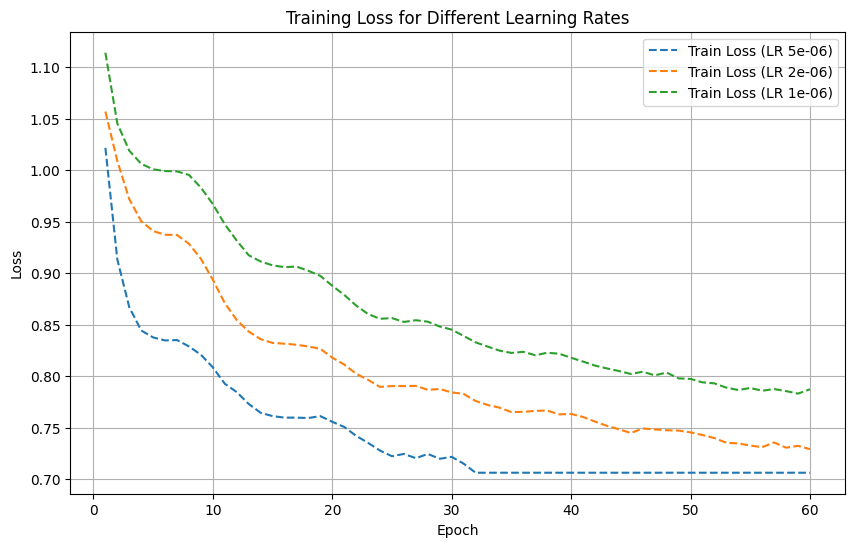

In [ ]:
# Plots the results

plt.figure(figsize=(10, 6))

for lr, losses in all_train_losses.items():
    plt.plot(range(1, EPOCHS + 1), losses, label=f"Train Loss ({lr})", linestyle="dashed")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for Different Learning Rates")
plt.legend()
plt.grid()
plt.show()


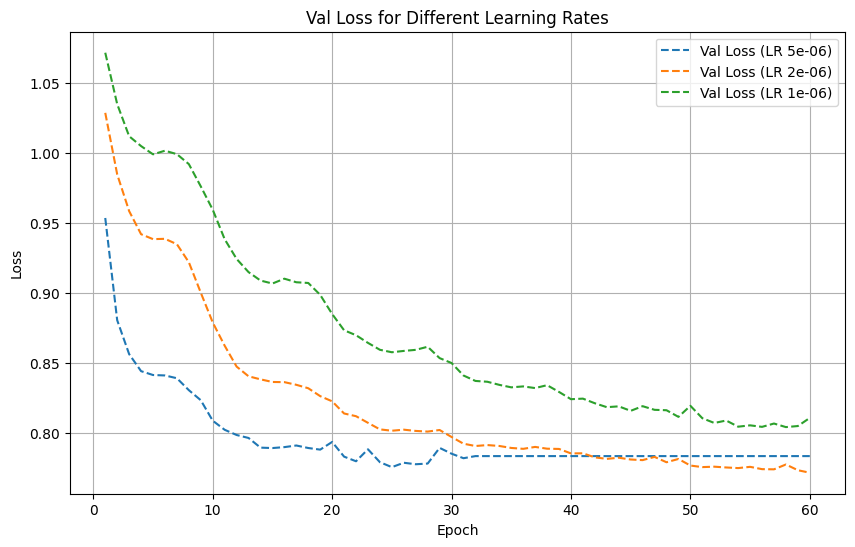

In [ ]:
# 📊 Plotando os resultados
plt.figure(figsize=(10, 6))

for lr, losses in all_val_losses.items():
    plt.plot(range(1, EPOCHS + 1), losses, label=f"Val Loss ({lr})", linestyle="dashed")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Val Loss for Different Learning Rates")
plt.legend()
plt.grid()
plt.show()

In [ ]:
CHOSEN_LR = 2e-6

neural_net_model = SentimentClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(neural_net_model.parameters(), lr=CHOSEN_LR, weight_decay=1e-5)  # Slight L2 Regularization
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)  # Gradual LR reduction

best_val_loss = float("inf")
patience_counter = 0

# Go through all epochs
for epoch in range(EPOCHS):
  train_loss = train(neural_net_model, embedding_train_loader, optimizer, criterion, epoch)
  val_loss, val_acc = test(neural_net_model, embedding_val_loader, criterion, epoch)

  # Update the learning rate with the scheduler
  scheduler.step()

  # Early Stopping: stop if the validation loss hasn't got any better for "PATIENCE" epochs
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    patience_counter = 0
  else:
    patience_counter += 1
    if patience_counter >= PATIENCE:
      print(f"⏹️ Early Stopping activated in epoch {epoch+1}.")
      break

| Epoch [  0/ 60] Iter[  1/  6]		Loss: 1.0947 Acc@1: 40.625%
| Epoch [  0/ 60] Iter[ 51/  6]		Loss: 1.0848 Acc@1: 37.990%
| Epoch [  0/ 60] Iter[101/  6]		Loss: 1.0773 Acc@1: 40.084%
| Epoch [  0/ 60] Iter[151/  6]		Loss: 1.0769 Acc@1: 40.811%
| Epoch [  0/ 60] Iter[201/  6]		Loss: 1.0615 Acc@1: 41.395%
| Epoch [  0/ 60] Iter[251/  6]		Loss: 1.0460 Acc@1: 42.069%
| Epoch [  0/ 60] Iter[301/  6]		Loss: 0.9981 Acc@1: 42.639%

| Validation Epoch #0			Loss: 1.0641 Acc@1: 48.45%
| Epoch [  1/ 60] Iter[  1/  6]		Loss: 1.0563 Acc@1: 43.750%
| Epoch [  1/ 60] Iter[ 51/  6]		Loss: 0.9874 Acc@1: 48.131%
| Epoch [  1/ 60] Iter[101/  6]		Loss: 1.0066 Acc@1: 47.850%
| Epoch [  1/ 60] Iter[151/  6]		Loss: 1.0173 Acc@1: 48.489%
| Epoch [  1/ 60] Iter[201/  6]		Loss: 0.9944 Acc@1: 49.075%
| Epoch [  1/ 60] Iter[251/  6]		Loss: 1.0135 Acc@1: 49.714%
| Epoch [  1/ 60] Iter[301/  6]		Loss: 1.0396 Acc@1: 49.792%

| Validation Epoch #1			Loss: 1.0010 Acc@1: 53.04%
| Epoch [  2/ 60] Iter[  1/  6]		Loss: 0.9

# Finetuning-Based

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
def compute_metrics(eval_pred):
    """
    Computes accuracy using sklearn's accuracy_score for consistency with other evaluations.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

## Classic

**Q4** - please use an LLM compare your performences to a LLM

In [ ]:
bert = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels = 3)

print_trainable_parameters(bert)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 109484547 || all params: 109484547 || trainable%: 100.0


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=os.path.join(".", 'results_no_LoRA'),
    evaluation_strategy="epoch",
    num_train_epochs=1,
    report_to="none"  # Deactivates wandb
)


# Initialize Trainer
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.515800,0.518015,0.796215


TrainOutput(global_step=2748, training_loss=0.6016033344740778, metrics={'train_runtime': 1162.6748, 'train_samples_per_second': 18.908, 'train_steps_per_second': 2.364, 'total_flos': 2892142687666176.0, 'train_loss': 0.6016033344740778, 'epoch': 1.0})

In [ ]:
# Save the fine-tuned model and configuration
output_dir = os.path.join('.', 'results_no_LoRA')
trainer.model.save_pretrained(output_dir)
trainer.save_model(output_dir)
trainer.model.config.save_pretrained(output_dir)

## LoRA

**Q7** - please finetue with LORA an LLM to classify the sentiment (optional)

In [ ]:
# the rank you want to decompose matrices
r = 2
lora_config = LoraConfig(task_type=TaskType.SEQ_CLS, r=r, lora_alpha=1, lora_dropout=0.1)

bert = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels = 3)
bert_lora = get_peft_model(bert, lora_config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print_trainable_parameters(bert_lora)

trainable params: 76035 || all params: 109560582 || trainable%: 0.06939995992354257


In [ ]:
training_args_lora = TrainingArguments(
    output_dir=os.path.join(".", 'results_LoRA'),
    evaluation_strategy="epoch",
    num_train_epochs=1,
    report_to="none"  # Deactivates wandb
)

# Initialize Trainer
trainer_lora = Trainer(
    model=bert_lora,
    args=training_args_lora,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer_lora.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.960300,0.928899,0.541303


TrainOutput(global_step=2748, training_loss=1.03128693093379, metrics={'train_runtime': 818.6762, 'train_samples_per_second': 26.853, 'train_steps_per_second': 3.357, 'total_flos': 2894710193750016.0, 'train_loss': 1.03128693093379, 'epoch': 1.0})

In [ ]:
# Save the fine-tuned model and configuration
output_dir = os.path.join('.', 'results_LoRA')
trainer_lora.model.save_pretrained(output_dir)
trainer_lora.save_model(output_dir)
trainer_lora.model.config.save_pretrained(output_dir)

# Discussion and Results

**Q3** - please analyse all the performences and explain which is the best

In [ ]:
# Feature-based Approach

# Classical ML
rf = RandomForestClassifier(**rf_best_params)
rf.fit(train_embeddings_umap, y_train)

accuracy = rf.score(test_embeddings_umap, y_test)
print(f"RF Test Accuracy: {accuracy:.4f}")

# Deep Learning
criterion = nn.CrossEntropyLoss()

nn_total_test_loss = 0
nn_total_test_acc = 0

for epoch in range(EPOCHS):
  nn_test_loss, nn_test_acc = test(neural_net_model, embedding_test_loader, criterion, epoch)
  nn_total_test_loss += nn_test_loss
  nn_total_test_acc += nn_test_acc
print(f"NN Test Accuracy: {nn_total_test_acc/EPOCHS:.4f}")

# Finetuning Approach

# Basic
finetuning_test_pred = trainer.predict(test_dataset)
finetuning_logits = finetuning_test_pred.predictions
finetuning_labels = finetuning_test_pred.label_ids
finetuning_preds = np.argmax(finetuning_logits, axis = 1)
finetuning_acc = np.mean(finetuning_preds == finetuning_labels)
print(f"Finetuning BERT Test Accuracy: {finetuning_acc:.4f}")

finetuning_lora_test_pred = trainer_lora.predict(test_dataset)
finetuning_lora_logits = finetuning_lora_test_pred.predictions
finetuning_lora_labels = finetuning_lora_test_pred.label_ids
finetuning_lora_preds = np.argmax(finetuning_lora_logits, axis = 1)
finetuning_lora_acc = np.mean(finetuning_lora_preds == finetuning_lora_labels)
print(f"Finetuning (LoRA) BERT Test Accuracy: {finetuning_lora_acc:.4f}")

RF Test Accuracy: 0.4244

| Validation Epoch #0			Loss: 1.0983 Acc@1: 65.25%

| Validation Epoch #1			Loss: 0.4435 Acc@1: 65.25%

| Validation Epoch #2			Loss: 0.8068 Acc@1: 65.25%

| Validation Epoch #3			Loss: 0.7757 Acc@1: 65.25%

| Validation Epoch #4			Loss: 0.4072 Acc@1: 65.25%

| Validation Epoch #5			Loss: 0.8889 Acc@1: 65.25%

| Validation Epoch #6			Loss: 0.9113 Acc@1: 65.25%

| Validation Epoch #7			Loss: 0.7096 Acc@1: 65.25%

| Validation Epoch #8			Loss: 0.9876 Acc@1: 65.25%

| Validation Epoch #9			Loss: 0.6179 Acc@1: 65.25%

| Validation Epoch #10			Loss: 0.9391 Acc@1: 65.25%

| Validation Epoch #11			Loss: 0.8869 Acc@1: 65.25%

| Validation Epoch #12			Loss: 0.9006 Acc@1: 65.25%

| Validation Epoch #13			Loss: 0.7499 Acc@1: 65.25%

| Validation Epoch #14			Loss: 0.9019 Acc@1: 65.25%

| Validation Epoch #15			Loss: 0.7167 Acc@1: 65.25%

| Validation Epoch #16			Loss: 0.8528 Acc@1: 65.25%

| Validation Epoch #17			Loss: 0.8044 Acc@1: 65.25%

| Validation Epoch #18			Loss:

Finetuning BERT Test Accuracy: 0.7900


Finetuning (LoRA) BERT Test Accuracy: 0.5376
